In [42]:

import numpy as np # linear algebra
import pandas as pd 
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, merge, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
warnings.simplefilter(action='ignore', category=FutureWarning)



import os
DATA_DIRECTORY = "../input/home-credit-default-risk"



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [5]:
df_train = pd.read_csv(os.path.join(DATA_DIRECTORY, 'application_train.csv'))
df_test = pd.read_csv(os.path.join(DATA_DIRECTORY, 'application_test.csv'))
df = df_train.append(df_test)
del df_train, df_test; gc.collect()

30

In [6]:
df = df[df['AMT_INCOME_TOTAL'] < 20000000]
df = df[df['CODE_GENDER'] != 'XNA']
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [7]:
def get_age_group(days_birth):
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [12]:
docs = [f for f in df.columns if 'FLAG_DOC' in f]
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_group(x))

In [9]:
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [10]:
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']    
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [13]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [14]:
def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [15]:
def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [16]:
def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


In [17]:
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [18]:
def label_encoder(df, categorical_columns=None):
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

In [19]:
def drop_application_columns(df):
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [20]:
df, le_encoded_cols = label_encoder(df, None)
df = drop_application_columns(df)

In [21]:
df = pd.get_dummies(df)

In [22]:
bureau = pd.read_csv(os.path.join(DATA_DIRECTORY, 'bureau.csv'))

In [23]:
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

In [24]:
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns

In [25]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [26]:
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [27]:
def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'))
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

In [28]:
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
bureau = bureau.merge(get_bureau_balance(DATA_DIRECTORY), how='left', on='SK_ID_BUREAU')
bureau['STATUS_12345'] = 0
for i in range(1,6):
    bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

In [29]:
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
del agg_length; gc.collect()

22

In [30]:
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

In [31]:
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
del active, closed; gc.collect()
for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()
for time_frame in [6, 12]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()
sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']

In [32]:
df = pd.merge(df, agg_bureau, on='SK_ID_CURR', how='left')
del agg_bureau, bureau
gc.collect()

22

In [33]:
prev = pd.read_csv(os.path.join(DATA_DIRECTORY, 'previous_application.csv'))
pay = pd.read_csv(os.path.join(DATA_DIRECTORY, 'installments_payments.csv'))

In [34]:
PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}
PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

In [35]:
ohe_columns = [
    'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
    'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
    'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

In [36]:
prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

In [37]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
active_pay_agg.reset_index(inplace= True)
active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                            active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
del active_pay, active_pay_agg, active_df; gc.collect()

0

In [38]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [44]:
prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
categorical_agg = {key: ['mean'] for key in categorical_cols}

In [46]:
agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
del active_agg_df; gc.collect()

0

In [47]:
agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
del approved, refused; gc.collect()

0

In [48]:
for loan_type in ['Consumer loans', 'Cash loans']:
    type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
    prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
    agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [49]:
pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()

In [50]:
agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
del agg_dpd, dpd_id; gc.collect()

0

In [51]:
for time_frame in [12, 24]:
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
del prev; gc.collect()

0

In [52]:
df = pd.merge(df, agg_prev, on='SK_ID_CURR', how='left')

In [53]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
del df
gc.collect()

44

In [54]:
labels = train['TARGET']
train = train.drop(columns=['TARGET'])
test = test.drop(columns=['TARGET'])

In [55]:
feature = list(train.columns)

train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df = test.copy()
train_df = train.copy()
train_df['TARGET'] = labels

In [56]:
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

In [57]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [58]:
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, labels)

LogisticRegression(C=0.0001)

In [59]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [60]:
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
submit.to_csv('log_reg.csv', index = False)

In [62]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [63]:
random_forest.fit(train, labels)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': feature, 'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:, 1]
del train, test
gc.collect()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


96

In [64]:
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = predictions
del predictions
submit.to_csv('random_forest.csv', index = False)
del submit
gc.collect()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


22

In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

# Ref: https://pranaysite.netlify.app/lightgbm/

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [66]:
submission, fi, metrics = model(train_df, test_df)
print('LightGBM metrics')
print(metrics)

Training Data Shape:  (307506, 460)
Testing Data Shape:  (48744, 460)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.836379	train's binary_logloss: 0.507279	valid's auc: 0.786856	valid's binary_logloss: 0.527756
[400]	train's auc: 0.874226	train's binary_logloss: 0.463384	valid's auc: 0.787999	valid's binary_logloss: 0.500531
Early stopping, best iteration is:
[305]	train's auc: 0.857886	train's binary_logloss: 0.48237	valid's auc: 0.788266	valid's binary_logloss: 0.512372
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.835379	train's binary_logloss: 0.508331	valid's auc: 0.789952	valid's binary_logloss: 0.528545
[400]	train's auc: 0.8731	train's binary_logloss: 0.465202	valid's auc: 0.79124	valid's binary_logloss: 0.501622
Early stopping, best iteration is:
[377]	train's auc: 0.869377	train's binary_logloss: 0.469522	valid's auc: 0.791432	valid's binary_logloss: 0.504252
Training until validation scores don't impro

In [68]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

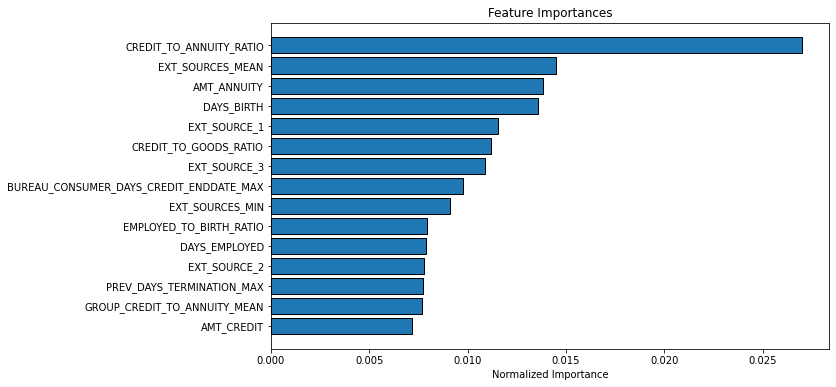

In [69]:
fi_sorted = plot_feature_importances(fi)


In [70]:
submission.to_csv('lgb.csv', index = False)
del submission, fi, fi_sorted, metrics
gc.collect()

4292

In [71]:
train_values = labels
train_id = train_df['SK_ID_CURR']
test_id = test_df['SK_ID_CURR']

train_df_xg = train_df.copy()
test_df_xg = test_df.copy()

train_df_xg.drop('SK_ID_CURR', inplace=True, axis=1)
test_df_xg.drop('SK_ID_CURR', inplace=True, axis=1)

train_df_xg, test_df_xg = train_df_xg.align(test_df_xg, join = 'inner', axis = 1)

ratio = (train_values == 0).sum()/ (train_values == 1).sum()
del train_df, test_df
gc.collect()

22

In [72]:
X_train, X_test, y_train, y_test = train_test_split(train_df_xg, train_values, test_size=0.2, stratify=train_values, random_state=1)

In [73]:
clf = XGBClassifier(n_estimators=1200, objective='binary:logistic', gamma=0.098, subsample=0.5, scale_pos_weight=ratio )
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.72084
[1]	validation_0-auc:0.73276
[2]	validation_0-auc:0.73861
[3]	validation_0-auc:0.74296
[4]	validation_0-auc:0.74567
[5]	validation_0-auc:0.74843
[6]	validation_0-auc:0.74927
[7]	validation_0-auc:0.75232
[8]	validation_0-auc:0.75474
[9]	validation_0-auc:0.75590
[10]	validation_0-auc:0.75751
[11]	validation_0-auc:0.75852
[12]	validation_0-auc:0.76071
[13]	validation_0-auc:0.76143
[14]	validation_0-auc:0.76229
[15]	validation_0-auc:0.76218
[16]	validation_0-auc:0.76290
[17]	validation_0-auc:0.76352
[18]	validation_0-auc:0.76387
[19]	validation_0-auc:0.76373
[20]	validation_0-auc:0.76355
[21]	validation_0-auc:0.76290
[22]	validation_0-auc:0.76321
[23]	validation_0-auc:0.76354
[24]	validation_0-auc:0.76308
[25]	validation_0-auc:0.76282
[26]	validation_0-auc:0.76276
[27]	validation_0-auc:0.76333
[28]	validation_0-auc:0.76333


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.098, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.387447631324525,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [74]:
predictions = clf.predict_proba(test_df_xg.values)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR': test_id.values, 'TARGET': predictions})
submission.to_csv('xgboost.csv', index = False)

In [75]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Embedding Neural Network ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Embedding Neural Network Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.show()

In [76]:
def preprocessing(input_dir, debug=False):
    # No target encoding
    num_rows = 10000 if debug else None
    
    print('Preprocessing started.')
    print('Bureau_Balance')
    buro_bal = pd.read_csv(input_dir + 'bureau_balance.csv', nrows=num_rows)
    
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
    
    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    del buro_bal
    gc.collect()
    
    print('Bureau')
    buro_full = pd.read_csv(input_dir + 'bureau.csv', nrows=num_rows)

    gc.collect()
    
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
    
    avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    
    del buro_full
    gc.collect()
    
    print('Previous_Application')
    prev = pd.read_csv(input_dir + 'previous_application.csv', nrows=num_rows)
    
    prev_cat_features = [
        f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    ]
    
    
    nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
    
    avg_prev = prev.groupby('SK_ID_CURR').mean()
    del prev
    gc.collect()
    
    print('POS_CASH_Balance')
    pos = pd.read_csv(input_dir + 'POS_CASH_balance.csv', nrows=num_rows)
    
    
    nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_pos = pos.groupby('SK_ID_CURR').mean()
    
    del pos, nb_prevs
    gc.collect()
    
    print('Credit_Card_Balance')
    cc_bal = pd.read_csv(input_dir + 'credit_card_balance.csv', nrows=num_rows)

    nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
    
    del cc_bal, nb_prevs
    gc.collect()
    
    print('Installments_Payments')
    inst = pd.read_csv(input_dir + 'installments_payments.csv', nrows=num_rows)
    nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_inst = inst.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]
    
    print('Train/Test')
    data = pd.read_csv(input_dir + 'application_train.csv', nrows=num_rows)
    test = pd.read_csv(input_dir + 'application_test.csv', nrows=num_rows)
    print('Shapes : ', data.shape, test.shape)
        
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()
    
    print('Preprocessing done.')

    return data, test

In [77]:
train, test = preprocessing('../input/home-credit-default-risk/', debug=False)

Preprocessing started.
Bureau_Balance
Bureau
Previous_Application
POS_CASH_Balance
Credit_Card_Balance
Installments_Payments
Train/Test
Shapes :  (307511, 122) (48744, 121)
Preprocessing done.


In [78]:
# Drop the target and the ID
X_train, y_train = train.iloc[:,2:], train.TARGET
X_test = test.iloc[:,1:]

In [79]:
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype == object}

In [80]:
nb_numeric   = len(X_train.columns) - len(col_vals_dict)
nb_categoric = len(col_vals_dict)
print('Number of Numerical features:', nb_numeric)
print('Number of Categorical features:', nb_categoric)

Number of Numerical features: 173
Number of Categorical features: 16


In [81]:
# Store the labels of each features
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype == object}

In [82]:
# Generator to parse the cat
generator = (c for c in X_train.columns if X_train[c].dtype == object)

# Label Encoder
for c in generator:
    lbl = LabelEncoder()
    lbl.fit(list(X_train[c].values) + list(X_test[c].values))
    X_train[c] = lbl.transform(list(X_train[c].values))
    X_test[c] = lbl.transform(list(X_test[c].values))

In [84]:
embed_cols = []
len_embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        len_embed_cols.append(len(col_vals_dict[c]))
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions
        
print('\n Number of embed features :', len(embed_cols))

CODE_GENDER: 3 values
NAME_TYPE_SUITE: 8 values
NAME_INCOME_TYPE: 8 values
NAME_EDUCATION_TYPE: 5 values
NAME_FAMILY_STATUS: 6 values
NAME_HOUSING_TYPE: 6 values
OCCUPATION_TYPE: 19 values
WEEKDAY_APPR_PROCESS_START: 7 values
ORGANIZATION_TYPE: 58 values
FONDKAPREMONT_MODE: 5 values
HOUSETYPE_MODE: 4 values
WALLSMATERIAL_MODE: 8 values
EMERGENCYSTATE_MODE: 3 values

 Number of embed features : 13


In [85]:
def build_embedding_network(len_embed_cols):
    
    model_out = []
    model_in  = []
    
    for dim in len_embed_cols:
        input_dim = Input(shape=(1,), dtype='int32')
        embed_dim = Embedding(dim, dim//2, input_length=1)(input_dim)
        embed_dim = Dropout(0.25)(embed_dim)
        embed_dim = Reshape((dim//2,))(embed_dim)
        model_out.append(embed_dim)
        model_in.append(input_dim)
    
    input_num = Input(shape=(176,), dtype='float32')
    outputs = Concatenate(axis=1)([*model_out, input_num])
    
    outputs = (Dense(128))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.35))(outputs)
    outputs = (Dense(64))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(32))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    
    model = Model([*model_in, input_num], outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [86]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

In [87]:
proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train, X_train, X_test)
print('Length of the list:', len(proc_X_train_f))

Length of the list: 14


In [88]:
proc_X_train_f

[array([1, 0, 1, ..., 0, 0, 0]),
 array([6, 1, 6, ..., 6, 6, 6]),
 array([7, 4, 7, ..., 7, 1, 1]),
 array([4, 1, 4, ..., 1, 4, 1]),
 array([3, 1, 3, ..., 2, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([ 8,  3,  8, ..., 10,  8,  8]),
 array([6, 1, 1, ..., 4, 6, 4]),
 array([ 5, 39, 11, ..., 39,  3,  5]),
 array([3, 3, 0, ..., 3, 0, 0]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([5, 0, 7, ..., 4, 5, 4]),
 array([0, 0, 2, ..., 0, 0, 0]),
 array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         -3.15421053e+02,  1.15592471e+04,  1.15592471e+04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.38532000e+03,  6.47545860e+04,  6.47545860e+04],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         -7.61666667e+02,  7.09615500e+03,  7.09615500e+03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         -2.38742857e+03,  4.39970786e+03,  4.11591536e+03],
        [ 0.00000000e+00,  0.00000000e+00,

In [89]:
print(proc_X_train_f[12].shape)

(307511,)


In [90]:
del proc_X_train_f, proc_X_val_f, proc_X_test_f
gc.collect()

154

In [91]:
num_cols = [x for x in X_train.columns if x not in embed_cols]


# Impute missing values in order to scale
X_train[num_cols] = X_train[num_cols].fillna(value = 0)
X_test[num_cols] = X_test[num_cols].fillna(value = 0)

# Fit the scaler only on train data
scaler = MinMaxScaler().fit(X_train[num_cols])
X_train.loc[:,num_cols] = scaler.transform(X_train[num_cols])
X_test.loc[:,num_cols] = scaler.transform(X_test[num_cols])

In [92]:
K = 5
runs_per_fold = 1
n_epochs = 250
patience = 10

cv_aucs   = []
full_val_preds = np.zeros(np.shape(X_train)[0])
y_preds = np.zeros((np.shape(X_test)[0],K))

kfold = StratifiedKFold(n_splits = K,  
                            shuffle = True, random_state=1)

for i, (f_ind, outf_ind) in enumerate(kfold.split(X_train, y_train)):

    X_train_f, X_val_f = X_train.loc[f_ind].copy(), X_train.loc[outf_ind].copy()
    y_train_f, y_val_f = y_train[f_ind], y_train[outf_ind]
    
    X_test_f = X_test.copy()
    
    
    # Shuffle data
    idx = np.arange(len(X_train_f))
    np.random.shuffle(idx)
    X_train_f = X_train_f.iloc[idx]
    y_train_f = y_train_f.iloc[idx]
    
    #preprocessing
    proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train_f, X_val_f, X_test_f)
    
    #track oof prediction for cv scores
    val_preds = 0
    
    for j in range(runs_per_fold):
    
        NN = build_embedding_network(len_embed_cols)

        # Set callback functions to early stop training and save the best model so far
        callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]

        NN.fit(proc_X_train_f, y_train_f.values, epochs=n_epochs, batch_size=4096, verbose=1,callbacks=callbacks,validation_data=(proc_X_val_f, y_val_f))
        
        val_preds += NN.predict(proc_X_val_f)[:,0] / runs_per_fold
        y_preds[:,i] += NN.predict(proc_X_test_f)[:,0] / runs_per_fold
        
    full_val_preds[outf_ind] += val_preds
        
    cv_auc  = roc_auc_score(y_val_f.values, val_preds)
    cv_aucs.append(cv_auc)
    print ('\nFold %i prediction cv AUC: %.5f\n' %(i,cv_auc))
    
print('Mean out of fold AUC: %.5f' % np.mean(cv_auc))
print('Full validation AUC: %.5f' % roc_auc_score(y_train.values, full_val_preds))

Epoch 1/250
61/61 [==============================] - 5s 39ms/step - loss: 0.3934 - val_loss: 0.2727
Epoch 2/250
61/61 [==============================] - 2s 31ms/step - loss: 0.2808 - val_loss: 0.2602
Epoch 3/250
61/61 [==============================] - 2s 29ms/step - loss: 0.2668 - val_loss: 0.2555
Epoch 4/250
61/61 [==============================] - 2s 30ms/step - loss: 0.2598 - val_loss: 0.2542
Epoch 5/250
61/61 [==============================] - 2s 36ms/step - loss: 0.2600 - val_loss: 0.2545
Epoch 6/250
61/61 [==============================] - 2s 34ms/step - loss: 0.2568 - val_loss: 0.2529
Epoch 7/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2562 - val_loss: 0.2528
Epoch 8/250
61/61 [==============================] - 2s 30ms/step - loss: 0.2562 - val_loss: 0.2524
Epoch 9/250
61/61 [==============================] - 2s 31ms/step - loss: 0.2564 - val_loss: 0.2525
Epoch 10/250
61/61 [==============================] - 2s 29ms/step - loss: 0.2547 - val_loss: 0.2518

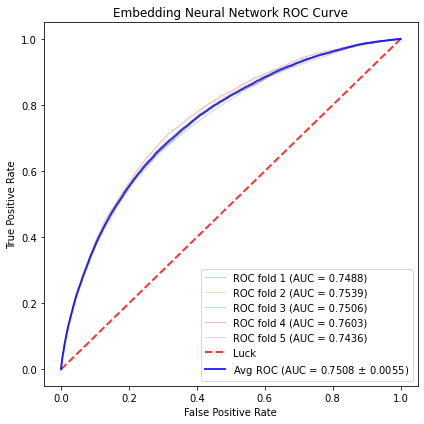

In [93]:
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in kfold.split(X_train, y_train)]
display_roc_curve(y_=y_train, oof_preds_=full_val_preds, folds_idx_=folds_idx)

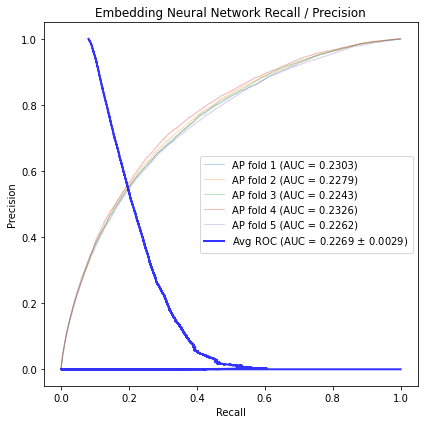

In [94]:
display_precision_recall(y_=y_train, oof_preds_=full_val_preds, folds_idx_=folds_idx)

In [95]:
test['TARGET'] = np.mean(y_preds, axis=1)
test = test[['SK_ID_CURR', 'TARGET']]
out_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': test['TARGET']})
out_df.to_csv('nn_embedding_submission.csv', index=False)